<div class="row">
  <div class="col-sm-8">
     <center>
        <h1>
        <img src="https://s3-eu-west-1.amazonaws.com/assets.atout-on-line.com/images/ingenieur/Fiches_Ecoles/telecom_paristech.jpg" alt="drawing" width="200"/>
            <br><br>
        IA 716 - Computer Vision<br>
        Projet 1
        <hr class="bg-light" />
            <i>Alexandre LE BRIS<br></i>
            <i>MS IA - 21/22<br></i>
        </h1>
    </center>
  </div>
          
  </div>
</div>

***
***

## Import packages

In [120]:
# Manage Google Colab environment if needed
import sys

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    #from google.colab import drive
    #drive.mount('/content/drive')
    if 'pytorch_lightning' not in sys.modules:
        !pip install pytorch_lightning
else:
    # Fix bug on DataLoader (pickling lambda function in multiprocessing context)
    try:
        import multiprocessing
        multiprocessing.set_start_method("fork")
    except: pass

In [121]:
# Import packages
import os
import numpy as np
from tqdm.notebook import tqdm
from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.optim as optim

import torchvision
from torchvision.datasets import MNIST, SVHN
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateMonitor,
    ModelSummary,
)

# Setting the graphics
# %matplotlib inline
sns.set_style('dark')

# Setting the resources
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)
#NUM_WORKERS = 0

# Setting the seed
pl.seed_everything(42);

Global seed set to 42


In [122]:
# Setting main constants
BATCH_SIZE = 64

## Import data

In [123]:
class NumDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "data",
                 batch_size: int = BATCH_SIZE,
                 train_valid_ratio: float = 0.9,
                 num_workers: int = NUM_WORKERS):
        super(NumDataModule, self).__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_valid_ratio = train_valid_ratio
        self.num_workers = num_workers

        def rescale(x: torch.float):
            return x * 2. - 1.
        self.transform = [
                          transforms.ToTensor(),
                          transforms.Lambda(rescale),
                         ]
        self.setup()

    def setup(self):
        """
        Downloads the data, parse it and split the data into train, test, validation data
        """
        def bw2col(x: torch.float):
            return x.repeat(3, 1, 1)
        transform_list = transforms.Compose(self.transform +
                                            [
                                             transforms.Resize(32),  # resize to [32,32],
                                             transforms.Lambda(bw2col),
                                             #transforms.ToPILImage(),
                                            ])

        # Creation of MNIST datasets
        mnist_full = MNIST(self.data_dir, download=True,
                           train=True, transform=transform_list)
        len_train = int(len(mnist_full) * self.train_valid_ratio)
        len_val = len(mnist_full) - len_train
        self.mnist_train, self.mnist_val = random_split(mnist_full,
                                                        [len_train, len_val])
        self.mnist_test = MNIST(self.data_dir, download=True,
                                train=False, transform=transform_list)

        # Creation of SVHN datasets
        svhn_full = SVHN(self.data_dir, download=True, split='train',
                         transform=transforms.Compose(self.transform))
        len_train = int(len(svhn_full) * self.train_valid_ratio)
        len_val = len(svhn_full) - len_train
        self.svhn_train, self.svhn_val = random_split(svhn_full,
                                                      [len_train, len_val])
        self.svhn_test = SVHN(self.data_dir, download=True, split='test',
                              transform=transforms.Compose(self.transform))

    def train_dataloader(self):
        """
        :return: output - Train data loader for the given input
        """
        loader_mnist = DataLoader(dataset=self.mnist_train,
                                  batch_size=self.batch_size,
                                  num_workers=self.num_workers,
                                  shuffle=True,
                                  drop_last=True)
        loader_svhn = DataLoader(dataset=self.svhn_train,
                                 batch_size=self.batch_size,
                                 num_workers=self.num_workers,
                                 shuffle=True,
                                 drop_last=True)
        return {'mnist': loader_mnist, 'svhn': loader_svhn}

    def val_dataloader(self):
        """
        :return: output - Validation data loader for the given input
        """
        loader_mnist = DataLoader(dataset=self.mnist_val,
                                  batch_size=self.batch_size,
                                  num_workers=self.num_workers,
                                  shuffle=True,
                                  drop_last=True)
        loader_svhn = DataLoader(dataset=self.svhn_val,
                                 batch_size=self.batch_size,
                                 num_workers=self.num_workers,
                                 shuffle=True,
                                 drop_last=True)
        return {'mnist': loader_mnist, 'svhn': loader_svhn}

    def test_dataloader(self):
        """
        :return: output - Test data loader for the given input
        """
        loader_mnist = DataLoader(dataset=self.mnist_test,
                                  batch_size=self.batch_size,
                                  num_workers=self.num_workers,
                                  shuffle=True,
                                  drop_last=True)
        loader_svhn = DataLoader(dataset=self.svhn_test,
                                 batch_size=self.batch_size,
                                 num_workers=self.num_workers,
                                 shuffle=True,
                                 drop_last=True)
        return {'mnist': loader_mnist, 'svhn': loader_svhn}

In [124]:
dm = NumDataModule()

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


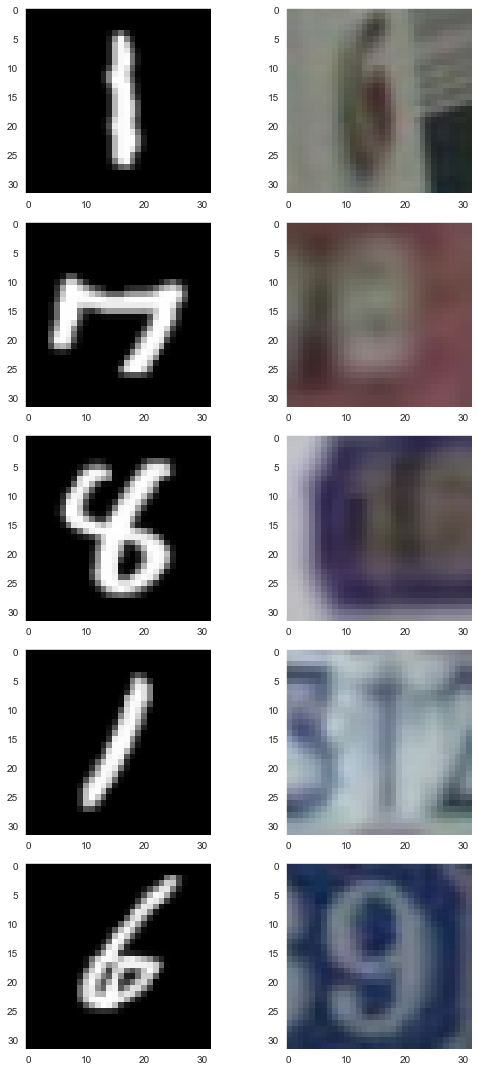

In [125]:
N = 5
train = dm.train_dataloader()
train_mnist = train['mnist'].dataset
train_svhn = train['svhn'].dataset

fig, ax = plt.subplots(nrows=N, ncols=2, figsize=(8, 15))
for i in range(N):
    idx_mnist = torch.randint(len(train_mnist), size=(1,)).item()
    img, label = train_mnist[idx_mnist]
    ax[i, 0].imshow((img.permute((1, 2, 0)) + 1) / 2, cmap='binary',
                    interpolation='nearest')
    
    idx_svhn = torch.randint(len(train_svhn), size=(1,)).item()
    img, label = train_svhn[idx_svhn]
    ax[i, 1].imshow((img.permute((1, 2, 0)) + 1) / 2, interpolation='nearest')
plt.tight_layout()
plt.show();

## Create AutoEncoder for MNIST data

In [148]:
class Encoder(nn.Module):
    def __init__(self,
                    input_channels: int,
                    latent_dim: int,
                    act_fn: object = nn.ReLU()):
            # Initialization of the Module and the attributes
            super().__init__()
            self.latent_dim = latent_dim
            self.input_channels = input_channels
            
            # Definition of the Encoder block
            self.encoder = nn.Sequential(
                nn.Conv2d(input_channels, 32, kernel_size=3, stride=1), # 32x32x3 -> 30x30x32
                act_fn,
                nn.Conv2d(32, 64, kernel_size=3, stride=2), # 30x30x32 -> 14x14x64
                act_fn,
                nn.Conv2d(64, 128, kernel_size=3, stride=2), # 14x14x64 -> 6x6x128
                act_fn,
                nn.Conv2d(128, 256, kernel_size=2, stride=2), # 6x6x128 -> 3x3x256
                act_fn,
                nn.Flatten(),
                nn.Linear(3 * 3 * 256, latent_dim)
            )
        
    def forward(self, x):
        z = self.encoder(x)
        return z

In [169]:
class Generator(nn.Module):
    def __init__(self,
                 latent_dim: int,
                 act_fn: object = nn.ReLU(inplace=True)):
        # Initialization of the Module and the attributes
        super().__init__()
        self.latent_dim = latent_dim
             
        # Definition of the Generator block
        self.linear = nn.Linear(latent_dim, 3 * 3 * 256)
        
        self.generator = nn.Sequential(
            nn.BatchNorm2d(256),
            act_fn,
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            act_fn,
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            act_fn,
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            act_fn,
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        z = self.linear(z)
        z = z.reshape(z.shape[0], -1, 3, 3)
        x_new = self.generator(z)
        return x_new

## Create the Discriminator

In [170]:
class Discriminator(nn.Module):
    def __init__(self, img_shape: tuple = (3, 32, 32),
                 act_fn: object = nn.LeakyReLU(0.2, inplace=True)):
        super().__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            act_fn,
            #nn.BatchNorm1d(512),
            #nn.Dropout(p=0.4),
            nn.Linear(512, 256),
            act_fn,
            #nn.BatchNorm1d(256),
            #nn.Dropout(p=0.4),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.flatten(start_dim=1)
        validity = self.discriminator(img_flat)

        return validity

In [179]:
class Discriminator(nn.Module):
    def __init__(self,
                 act_fn: object = nn.LeakyReLU(0.2, inplace=True)):
        super().__init__()

        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1), # 32x32x3 -> 30x30x32
            act_fn,
            nn.Conv2d(32, 64, kernel_size=3, stride=2), # 30x30x32 -> 14x14x64
            nn.BatchNorm2d(64),
            act_fn,
            nn.Conv2d(64, 128, kernel_size=3, stride=2), # 14x14x64 -> 6x6x128
            nn.BatchNorm2d(128),
            act_fn,
            nn.Conv2d(128, 256, kernel_size=2, stride=2), # 6x6x128 -> 3x3x256
            nn.BatchNorm2d(256),
            act_fn,
            nn.Flatten(),
            nn.Linear(3 * 3 * 256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        #img_flat = img.flatten(start_dim=1)
        validity = self.discriminator(img)

        return validity

## Create the GAN

We use Deep Convolutional GAN (DCGAN) architecture [Radford2015](https://arxiv.org/abs/1511.06434).

In [183]:
class GAN(pl.LightningModule):
    def __init__(
        self,
        latent_dim: int,
        lr: float = 0.0002,
        b1: float = 0.5,
        b2: float = 0.999,
        batch_size: int = BATCH_SIZE,
        **kwargs
    ):
        super().__init__()
        # Save the hyperparameters
        self.save_hyperparameters()
        
        # Initialize the layers
        self.generator = Generator(latent_dim=latent_dim,
                                   act_fn=nn.LeakyReLU(0.2, inplace=True))
        self.discriminator = Discriminator(act_fn=nn.LeakyReLU(0.2, inplace=True))
        
    def forward(self, x):
        return self.generator(x)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, _ = batch['svhn']

        # sample noise
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(imgs)

        generated_imgs = self(z)
        
        valid_label = torch.ones((imgs.shape[0], 1), device=self.device)
        fake_label = torch.zeros((imgs.shape[0], 1), device=self.device)
        
        # Phase 1 - Training the generator
        if optimizer_idx == 0:
            
            # log sampled images
            sample_imgs = generated_imgs[:6]
            grid = torchvision.utils.make_grid(sample_imgs)
            self.logger.experiment.add_image("generated_images", grid, 0)
            
            # adversarial loss is binary cross-entropy
            g_loss = self.adversarial_loss(self.discriminator(generated_imgs),
                                           valid_label)
            tqdm_dict = {"g_loss": g_loss}
            output = OrderedDict({"loss": g_loss, "progress_bar": tqdm_dict,
                                  "log": tqdm_dict})
            self.log("train_g_loss", g_loss, prog_bar=True)
            return output
        
        # Phase 2 - Training the discriminator
        # Measure discriminator's ability to classify real from generated samples
        if optimizer_idx == 1:

            real_loss = self.adversarial_loss(self.discriminator(imgs),
                                              valid_label)
            fake_loss = self.adversarial_loss(self.discriminator(generated_imgs).detach(),
                                              fake_label)

            # discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2
            tqdm_dict = {"d_loss": d_loss}
            output = OrderedDict({"loss": d_loss, "progress_bar": tqdm_dict,
                                  "log": tqdm_dict})
            self.log("train_d_loss", d_loss, prog_bar=True)
            return output

In [184]:
dm = NumDataModule()
model = GAN(100)
summary(model, (100,))
trainer = pl.Trainer(gpus=AVAIL_GPUS, max_epochs=5)
trainer.fit(model, dm)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 621 K 
1 | discriminator | Discriminator | 227 K 
------------------------------------------------
849 K     Train

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2304]         232,704
       BatchNorm2d-2            [-1, 256, 3, 3]             512
         LeakyReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 7, 7]         295,040
       BatchNorm2d-5            [-1, 128, 7, 7]             256
         LeakyReLU-6            [-1, 128, 7, 7]               0
   ConvTranspose2d-7           [-1, 64, 15, 15]          73,792
       BatchNorm2d-8           [-1, 64, 15, 15]             128
         LeakyReLU-9           [-1, 64, 15, 15]               0
  ConvTranspose2d-10           [-1, 32, 31, 31]          18,464
      BatchNorm2d-11           [-1, 32, 31, 31]              64
        LeakyReLU-12           [-1, 32, 31, 31]               0
  ConvTranspose2d-13            [-1, 3, 32, 32]             387
             Tanh-14            [-1, 3,

/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/pytorch_lightning/loops/optimization/closure.py:35: LightningDeprecationWarning: One of the returned values {'log', 'progress_bar'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(


Epoch 0:  28%|████▌           | 290/1030 [02:15<05:46,  2.13it/s, loss=2.28, v_num=15, train_g_loss=0.000116, train_d_loss=4.580]

/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [182]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
